In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler, scale
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, train_test_split, LeaveOneOut, KFold
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from scipy.stats import ttest_rel

from numpy import logspace, random, isnan
import pickle
from scipy.stats import rankdata
from os.path import basename

from json import dumps 

import shap
from copy import deepcopy

from sklearn.ensemble import RandomForestRegressor
import TraitData
from imp import reload
import seaborn as sns
reload(TraitData)
sns.set()
sns.set(font_scale=1.5)

cv = KFold(n_splits=10)

try:
    SAVED_STATE = pickle.load(open("np.random.state", 'rb'))
    np.random.set_state(SAVED_STATE)
except Exception as e:
    SAVED_STATE = False
    

%matplotlib inline
plt.rcParams['figure.figsize'] = (7,15)
%config InlineBackend.figure_format = 'retina'

<img style="float:right" src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png" width=60px)/>
<h1> Feature Interpretation Across Methods: A Study. <small> by: Tony Cannistra </small></h1>
We are attempting to understand the type and magnitude of the effects that various physiological or behavioral traits have had on historical range shifts.

The challenge is that standard linear regression has been only able to explain a small percentage of the variance seen in range shift data for several taxa ([Angert et al., 2011](http://onlinelibrary.wiley.com/doi/10.1111/j.1461-0248.2011.01620.x/abstract)). This is likely as a result of the relationships between predictor and response variables being something other than linear, especially since several variables have biological relevance for their ability to facilitate range shifts. 

## Load Data + Define Functions
For this exploration we have trait data for several large taxonomic groups of organisms and their observed range shifts over the past 100 years. There are 3 datasets
### Define Each Dataset

In [14]:
plantsData = {
    'name' : "Alpine Plants - Full",
    'file' : "../data/angert_etal_2011/plants5.csv",
    
    'responseVar'   : "migration_m",

    'drop_features' : ["Taxon",
                     "migr_sterr_m", 
                     "shift + 2SE", 
                     'signif_shift',
                     "signif_shift2",
                     "dispmode01",
                     "DispModeEng", ## what is this
                     "shift + 2SE", 
                      "Grime"],
    'categorical_features' : ["oceanity",
                            "dispersal_mode",
                            "BreedSysCode", "SI01"], 
    
    'traits_desc_file' : "../data/angert_etal_2011/traits-desc-plants.csv"
}

plantsData_extendedDrop = deepcopy(plantsData)
plantsData_extendedDrop['name'] = "Swiss Alpine Plants"
plantsData_extendedDrop.get('drop_features').extend(["Bio1_mean_nosyn",
                                                 "Bio1_std_nosyn",
                                                 "Bio1_var_nosyn", 
                                                 "Bio1_mean_inclsyn",
                                                 "Bio1_std_inclsyn",
                                                 "Bio1_var_inclsyn"])

mammalData = {
    'name' : "Mammals - Full",
    'file' : "../data/angert_etal_2011/mammals01.csv",
    
    'responseVar'   : "High_change",

    'drop_features' : ["Taxon",
                       "High_change_pfa2",
                       "Daily_rhythm_code",
                       "Annual_rhythm_code"],
    
    'categorical_features' : ["Daily01",
                              "Annual01",
                              "Food01",
                              "Daily_rhythm",
                              "Annual_rhythm",
                              "Food"],
    
    'traits_desc_file' : "../data/angert_etal_2011/traits-desc-mammals.csv"
}

mammalData_extendedDrop = deepcopy(mammalData)
mammalData_extendedDrop['name'] = "Mammals"
mammalData_extendedDrop.get("drop_features").extend(["Bio1_mean",
                                                     "Daily01_0",
                                                     "Daily01_1",
                                                     "Annual01_0",
                                                     "Annual01_1",
                                                     "Food01_0",
                                                     "Food01_1"])

triennialMarineData = {
    'name' : "Triennial Marine Survey -- Full",
    'file' : "../data/marine/west-coast-triennial _species_generaltraits.csv",
    'responseVar' : "Latitudinal Difference",
    
    'drop_features' : ["Species", "Latitudinal Std",
                      "FamCode", "GenCode"], 
    
    'categorical_features' : [
        "UsedforAquaculture",
        "Electrogenic",
        "DemersPelag",
        "LTypeMaxM", 
        "Fresh", 
        "Brack", 
        "Saltwater"
    ], 
    
    'traits_desc_file' : "../data/marine/traits-desc.csv"
}

triennialMarineData_extendedDrop = deepcopy(triennialMarineData)
triennialMarineData_extendedDrop['name'] = "Triennial Marine Survey"
triennialMarineData_extendedDrop.get("drop_features").extend(["Electrogenic_Electrosensing only",
                                                              "Electrogenic_electrosensing only",
                                                              "Electrogenic_no special ability",
                                                              "Electrogenic_strongly discharging",
                                                              "Electrogenic_weakly discharging",
                                                              "LTypeMaxM_FL","LTypeMaxM_SL", "LTypeMaxM_TL"])


TRYdata = {
    'name': "European Plants",
    'file': "../data/TRY/rumpf_ShiftsTraitsBuckley_20180418.csv",
    'responseVar' : "LeadingEdge", # there's also "RearEdge" and "Optimum"
    'drop_features' : ['speciesname',
                       'Dispersal',
                       'Persistence', 
                       'RearEdge', 
                       'Optimum'],
    'categorical_features': ['LifeStrategy']
}


datasets = {
    plantsData_extendedDrop['name'] : plantsData_extendedDrop,
    mammalData_extendedDrop['name'] : mammalData_extendedDrop,
    triennialMarineData_extendedDrop['name'] : triennialMarineData_extendedDrop,
    TRYdata['name'] : TRYdata
}
with open("DATA_SPECIFICATION.json", 'w') as dsjson:
    dsjson.write(dumps(list(d for k, d in datasets.items())))
                
all_mses = {}
rankings = []
MSEs = []
COEFs = []

print(", ".join(datasets.keys()))
print("filenames: {}".format(", ".join(d['name'].replace(" ", '-') for k, d in datasets.items())))


Triennial Marine Survey, Mammals, Swiss Alpine Plants, European Plants
filenames: Triennial-Marine-Survey, Mammals, Swiss-Alpine-Plants, European-Plants


---
### Select, Load, and Normalize Dataset

In [8]:
dataset = datasets['Mammals']
dsname = dataset['name'].replace(" ", "-")

dropNA  = 0

td = TraitData.TraitData(dataset['file'],
                         dataset['responseVar'],
                         dataset['drop_features'],
                         dataset['categorical_features'],
                         dropNA=dropNA, scale=True)
## rename traits
try: 
    traitnames = pd.read_csv(dataset['traits_desc_file']).fillna('')
    traitnames_map = { a:b for a, b in zip(traitnames.name, traitnames.description)}
    td.feature_names = [traitnames_map[trait] if traitnames_map[trait] != '' else trait for trait in td.feature_names]
    td.X.columns = td.feature_names
except: 
    print("No trait description.")
    
print(len(td.X))
display(td.X.head())
td.X = np.array(td.X)
td.Y = np.array(td.Y)

print(td.X.shape)
print("\n".join(td.feature_names))





No trait description.
28


/Users/tony/miniconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)
/Users/tony/miniconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


,Orig_high_limit,Litter_size,Litters_per_yr,Young_per_yr,Mass_g,Longevity_yrs,Bio1_std,Rangesize_km2,Food_code,Daily_rhythm_both,Daily_rhythm_diur,Daily_rhythm_noct,Annual_rhythm_fachib,Annual_rhythm_nonhib,Annual_rhythm_oblhib,Food_gran,Food_herb,Food_inse,Food_omni
0,-1.780427,-0.509175,0.210725,-0.385922,-0.305936,-0.658218,-1.570086,-0.674237,1,-0.688247,-0.745356,1.452966,-0.408248,0.688247,-0.466252,1,0,0,0
1,-1.659520,-1.527525,0.210725,-0.578884,-0.251574,0.944400,-0.709853,-0.690925,1,-0.688247,-0.745356,1.452966,-0.408248,0.688247,-0.466252,1,0,0,0
2,0.876267,0.509175,-0.969334,-0.578884,5.100035,2.547019,0.711794,-0.089662,2,-0.688247,1.341641,-0.688247,-0.408248,-1.452966,2.144761,0,1,0,0
3,-1.512470,1.527525,2.570843,3.087380,-0.263654,-1.058873,-1.153552,-0.604368,2,1.452966,-0.745356,-0.688247,-0.408248,0.688247,-0.466252,0,1,0,0
4,0.804376,-0.509175,1.390784,0.771845,-0.257614,-1.058873,0.892895,0.750643,2,1.452966,-0.745356,-0.688247,-0.408248,0.688247,-0.466252,0,1,0,0


(28, 19)
Orig_high_limit
Litter_size
Litters_per_yr
Young_per_yr
Mass_g
Longevity_yrs
Bio1_std
Rangesize_km2
Food_code
Daily_rhythm_both
Daily_rhythm_diur
Daily_rhythm_noct
Annual_rhythm_fachib
Annual_rhythm_nonhib
Annual_rhythm_oblhib
Food_gran
Food_herb
Food_inse
Food_omni


In [8]:
try:
    print(traitnames.description)
except:
    pass

In [9]:
pickle.dump(np.random.get_state(), open('np.random.state', 'wb'), )
X_train, X_test, Y_train, Y_test = train_test_split(td.X, td.Y, train_size=0.60)

## Learning

In [10]:
## Importance Plotting Function
def plot_importance(importances, names, title=None, std=None, ft="", save=None):
    sns.set()
    sns.set(font_scale=1.5)
    plt.rcParams['figure.figsize'] = (7,15)
    f, ax = plt.subplots()
    
    bar_indices = np.arange(len(names))
    bar_width = 0.45
    importances_ind = np.argsort(abs(importances))

    plt.barh(bar_indices,
             importances[importances_ind],
            align='center', color='#4b2e83', xerr=std)
    
    plt.figtext(1, 0, ft, ha='right')
    plt.yticks(bar_indices, np.array(names)[importances_ind])
    plt.title(title)
    plt.tight_layout()
    if(save is not None):
        plt.savefig(save, bbox='tight', dpi=200)
    plt.show()
    
def compute_ranks(importances, absolute=True):
    if absolute:
        sorted_idx =  abs(importances).argsort()[::-1]
    else:
        sorted_idx = importances.argsort()[::-1]
    return(np.arange(len(importances))[sorted_idx.argsort()])

### Linear Models
#### OLS

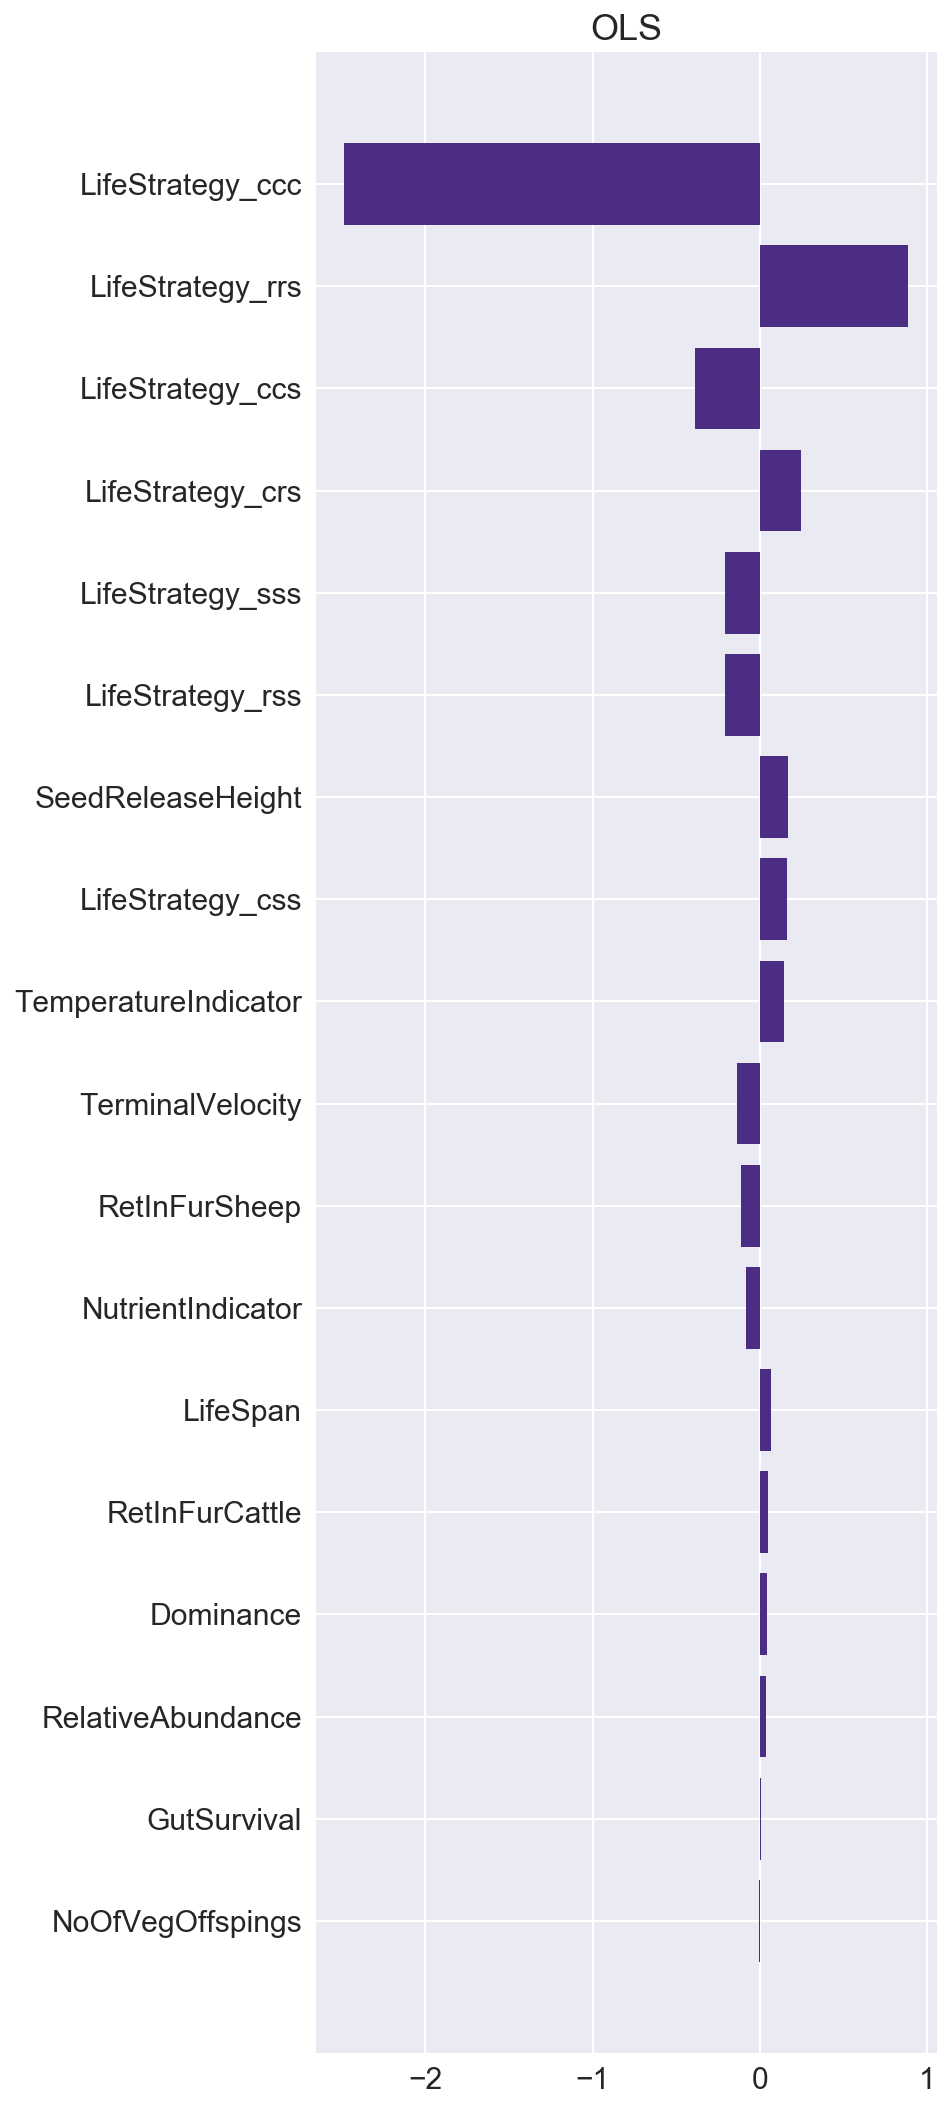

In [11]:
ols_coefs = []
ols_mses = []
for train, test in cv.split(td.X, td.Y):
    ols = LinearRegression(fit_intercept=False, normalize=False)
    ols.fit(td.X[train], td.Y[train])
    preds = ols.predict(td.X[test])
    error = mean_squared_error(td.Y[test], preds)
    ols_mses.append(error)
    ols_coefs.append(ols.coef_)
    
mean_error = np.mean(ols_mses)
std_error = np.std(ols_mses)
mean_coefs = np.mean(ols_coefs, axis=0)
std_coefs = np.std(ols_coefs, axis=0)

plot_importance(mean_coefs,
                td.feature_names, "OLS",
                save="{}_ols-ranks.png".format(dsname))#, std=std_coefs)
MSEs.append(("OLS", ols_mses))
COEFs.append(("OLS", mean_coefs))
rankings.append(['OLS'] + list(compute_ranks(mean_coefs)))


#### Ridge CV

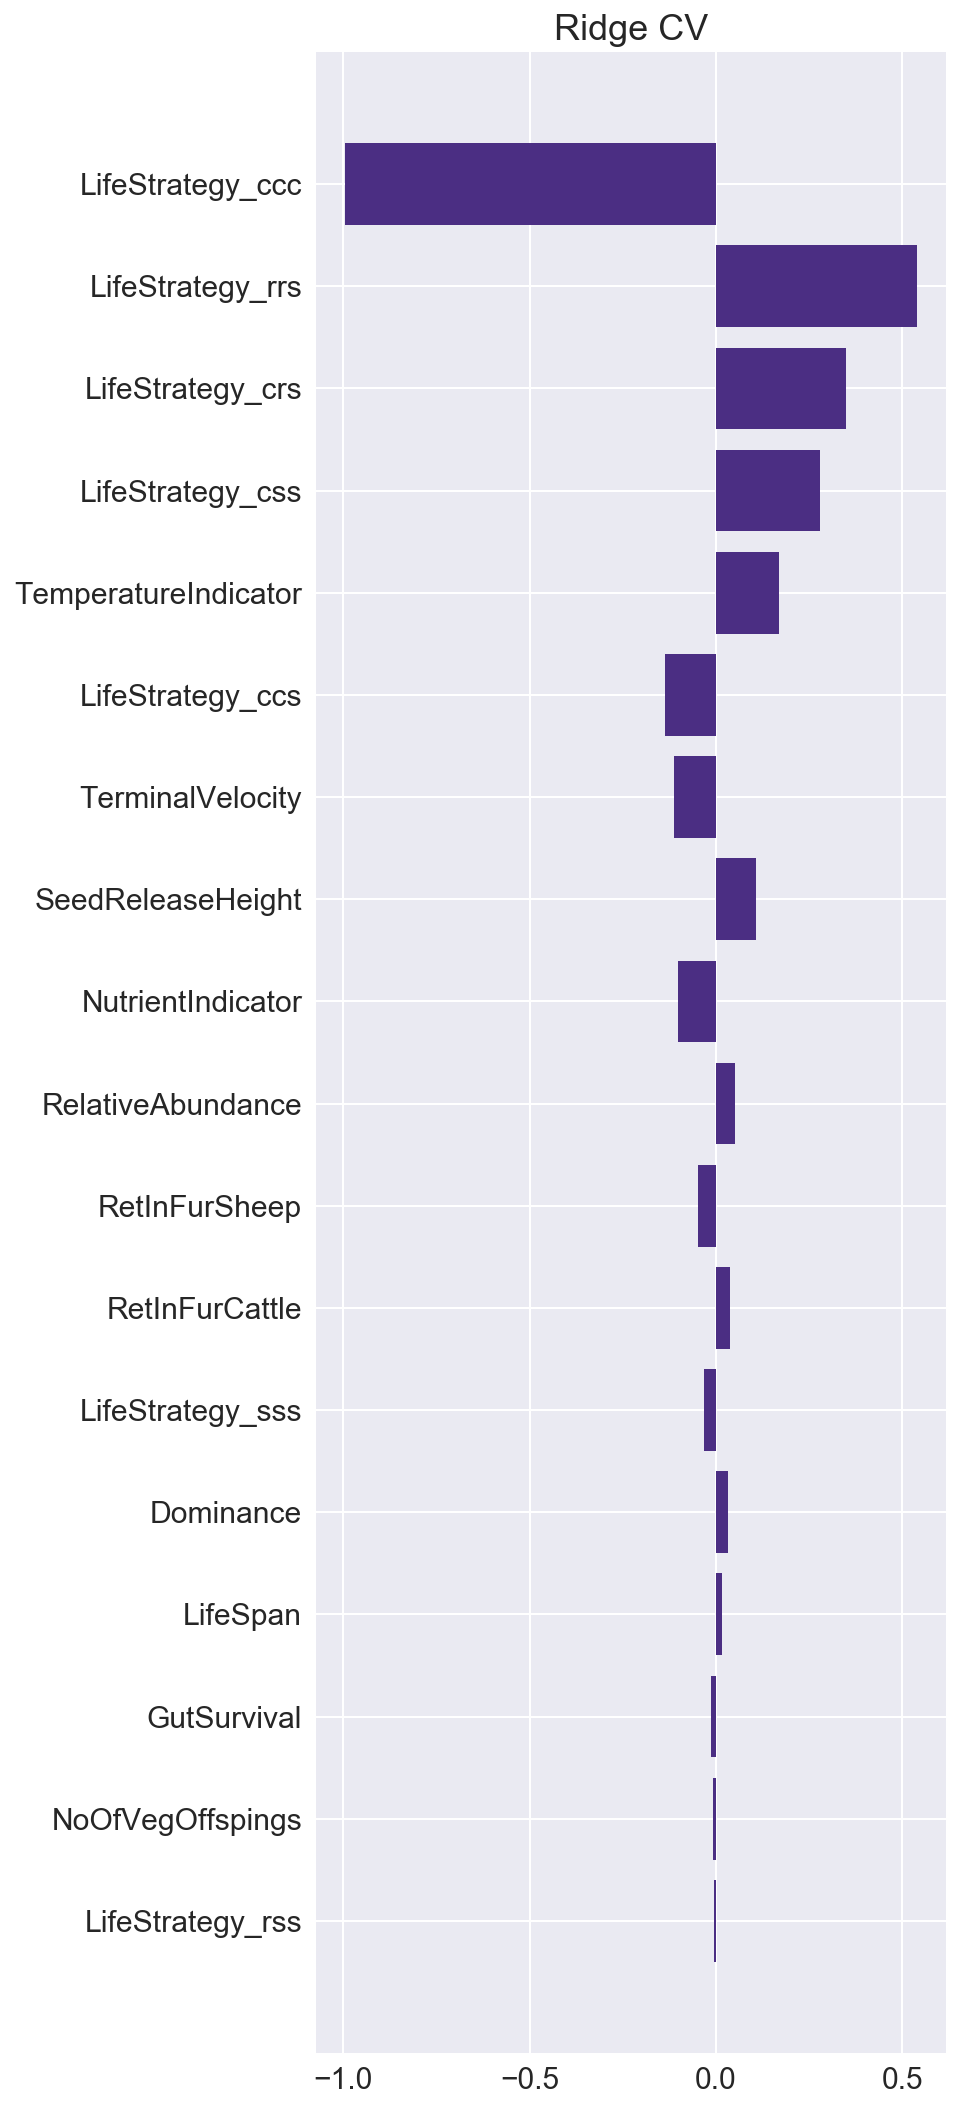

In [12]:
ridge_coefs = []
ridge_mses = []
for train, test in cv.split(td.X, td.Y):
    ridgecv = RidgeCV(normalize=False)
    ridgecv.fit(td.X[train], td.Y[train])
    preds = ridgecv.predict(td.X[test])
    error = mean_squared_error(td.Y[test], preds)
    ridge_mses.append(error)
    ridge_coefs.append(ridgecv.coef_)
    
mean_error = np.mean(ridge_mses)
std_error = np.std(ridge_mses)
mean_coefs = np.mean(ridge_coefs, axis=0)
std_coefs = np.std(ridge_coefs, axis=0)

    
plot_importance(mean_coefs, td.feature_names,  "Ridge CV",# std=std_coefs,
               save="{}_ridge-ranks.png".format(dsname))
rankings.append(['Ridge'] + list(compute_ranks(mean_coefs)))
MSEs.append(("Ridge", ridge_mses))
COEFs.append(("Ridge", mean_coefs))


#### Kernel Ridge

In [13]:
kernel_ridge_coefs = []
kernel_ridge_mses = []
for train, test in cv.split(td.X, td.Y):
    kr = KernelRidge(kernel='rbf')
    kr.fit(td.X[train], td.Y[train])
    preds = kr.predict(td.X[test])
    error = mean_squared_error(td.Y[test], preds)
    shapdata = shap.DenseData(td.X[train], td.feature_names)
    explainer = shap.KernelExplainer(kr.predict, shapdata, nsamples=100)
    kernel_ridge_coefs.append(explainer.explain(np.mat(td.X[test])).effects)
    kernel_ridge_mses.append(error)
    
#     for i in range(0, len(X_test)-1):
#         try: 
#             explanations.append(explainer.explain(np.mat(td.X[test][i:i+1, :])))
#         except Exception as e:
#             print("error on ", (i, i+1))
#             print(e)
#             continue



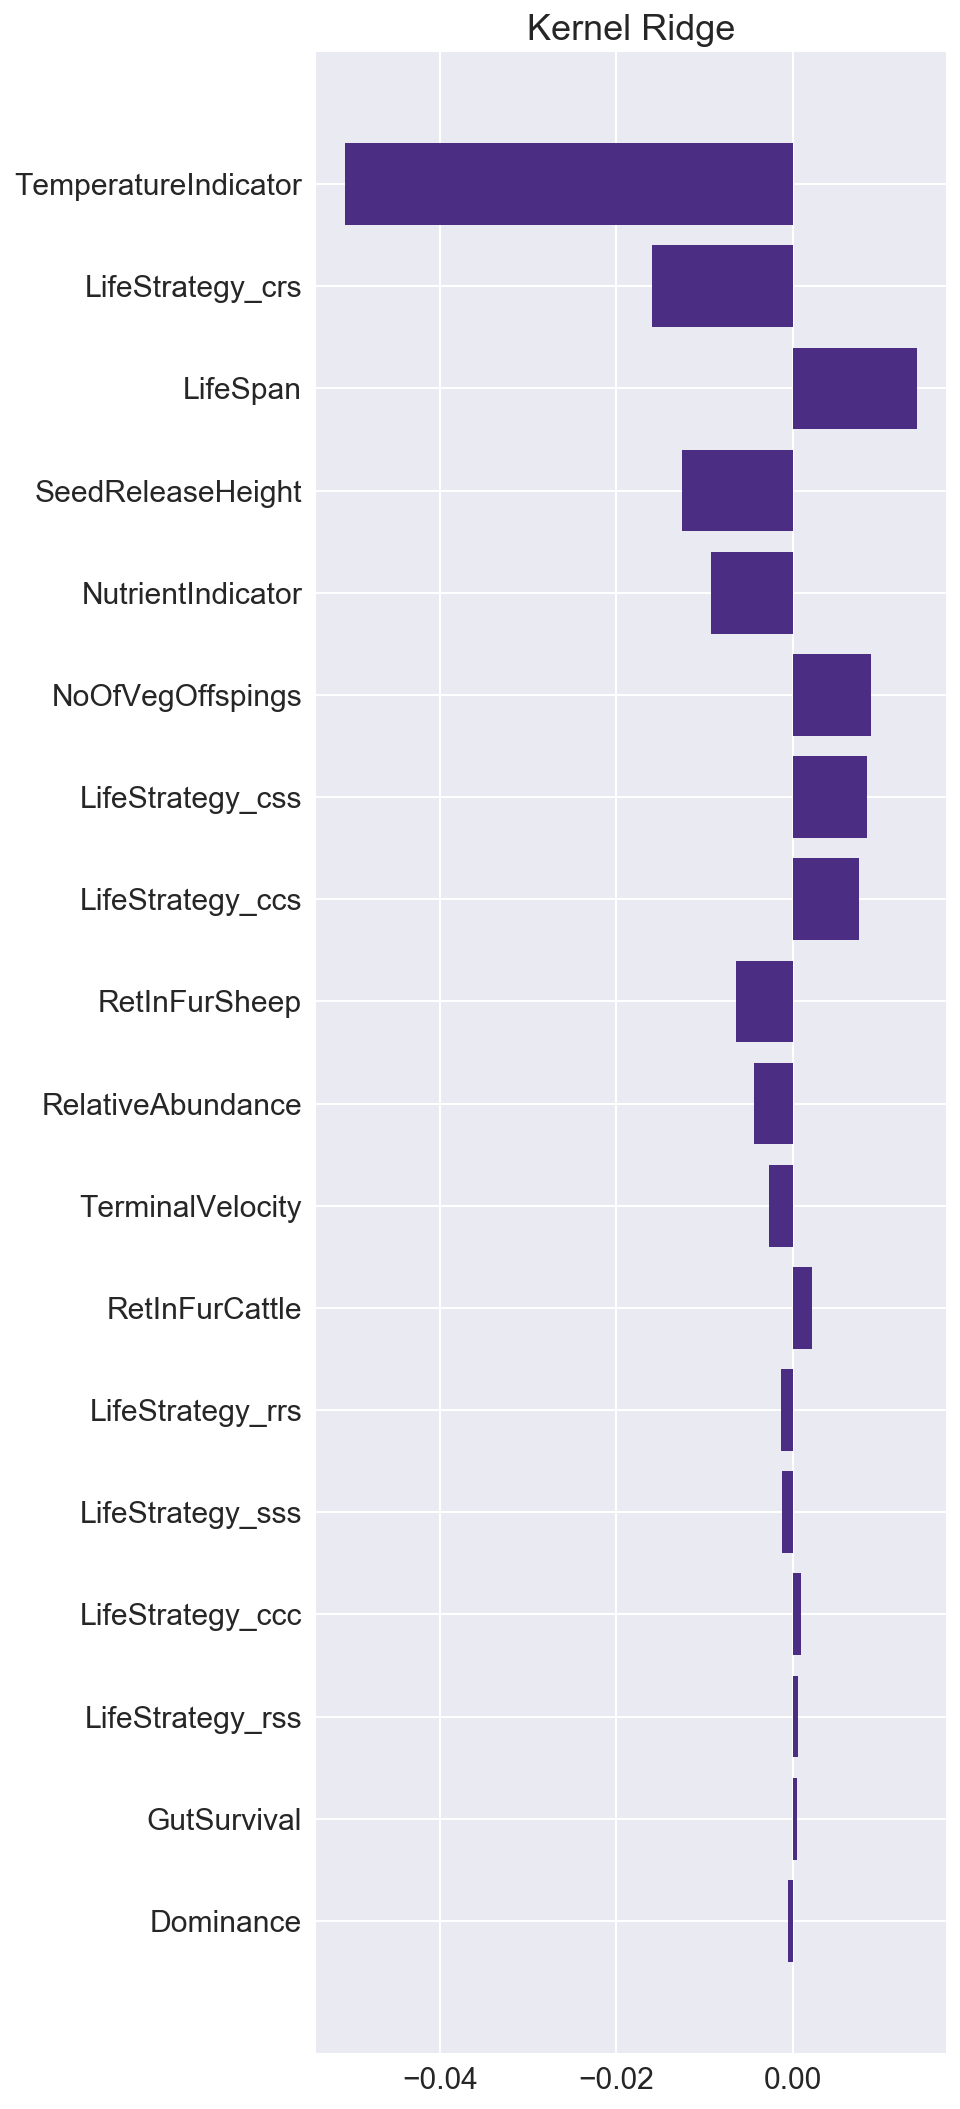

In [14]:
mean_error = np.mean(kernel_ridge_mses)
std_error = np.std(kernel_ridge_mses)
mean_coefs = np.mean(kernel_ridge_coefs, axis=0)
std_coefs = np.std(kernel_ridge_coefs, axis=0)
plot_importance(mean_coefs, td.feature_names, "Kernel Ridge", 
               save="{}_kernelridge-ranks.png".format(dsname))#, std=std_coefs)
MSEs.append(("Kernel Ridge", kernel_ridge_mses))
COEFs.append(("Kernel Ridge", mean_coefs))
rankings.append(['Kernel Ridge'] + list(compute_ranks(mean_coefs)))

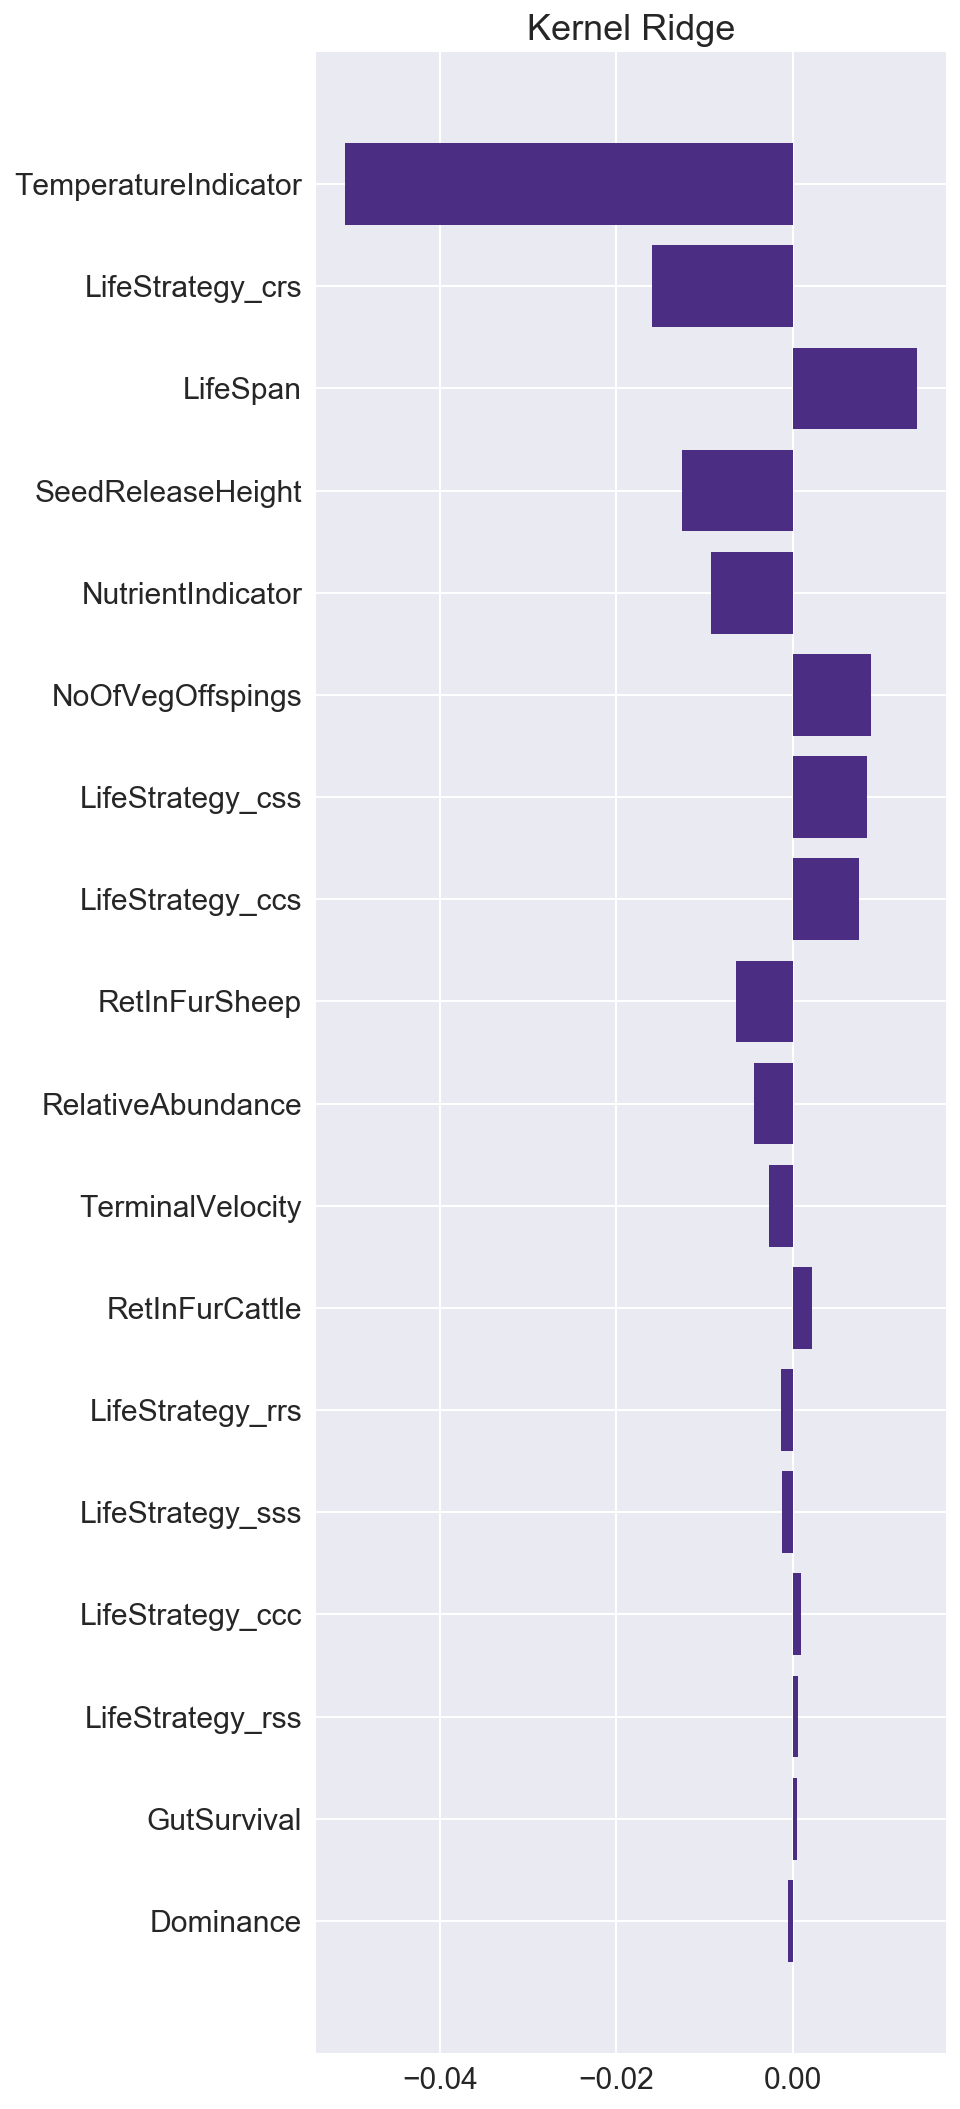

In [15]:
plot_importance(mean_coefs,
                td.feature_names,
                "Kernel Ridge", save="{}_kernelridge-nostd-ranks.png".format(dsname))
                #std=std_coefs)

rankings.append(['Kernel Ridge'] + list(compute_ranks(mean_coefs)))

### Trees

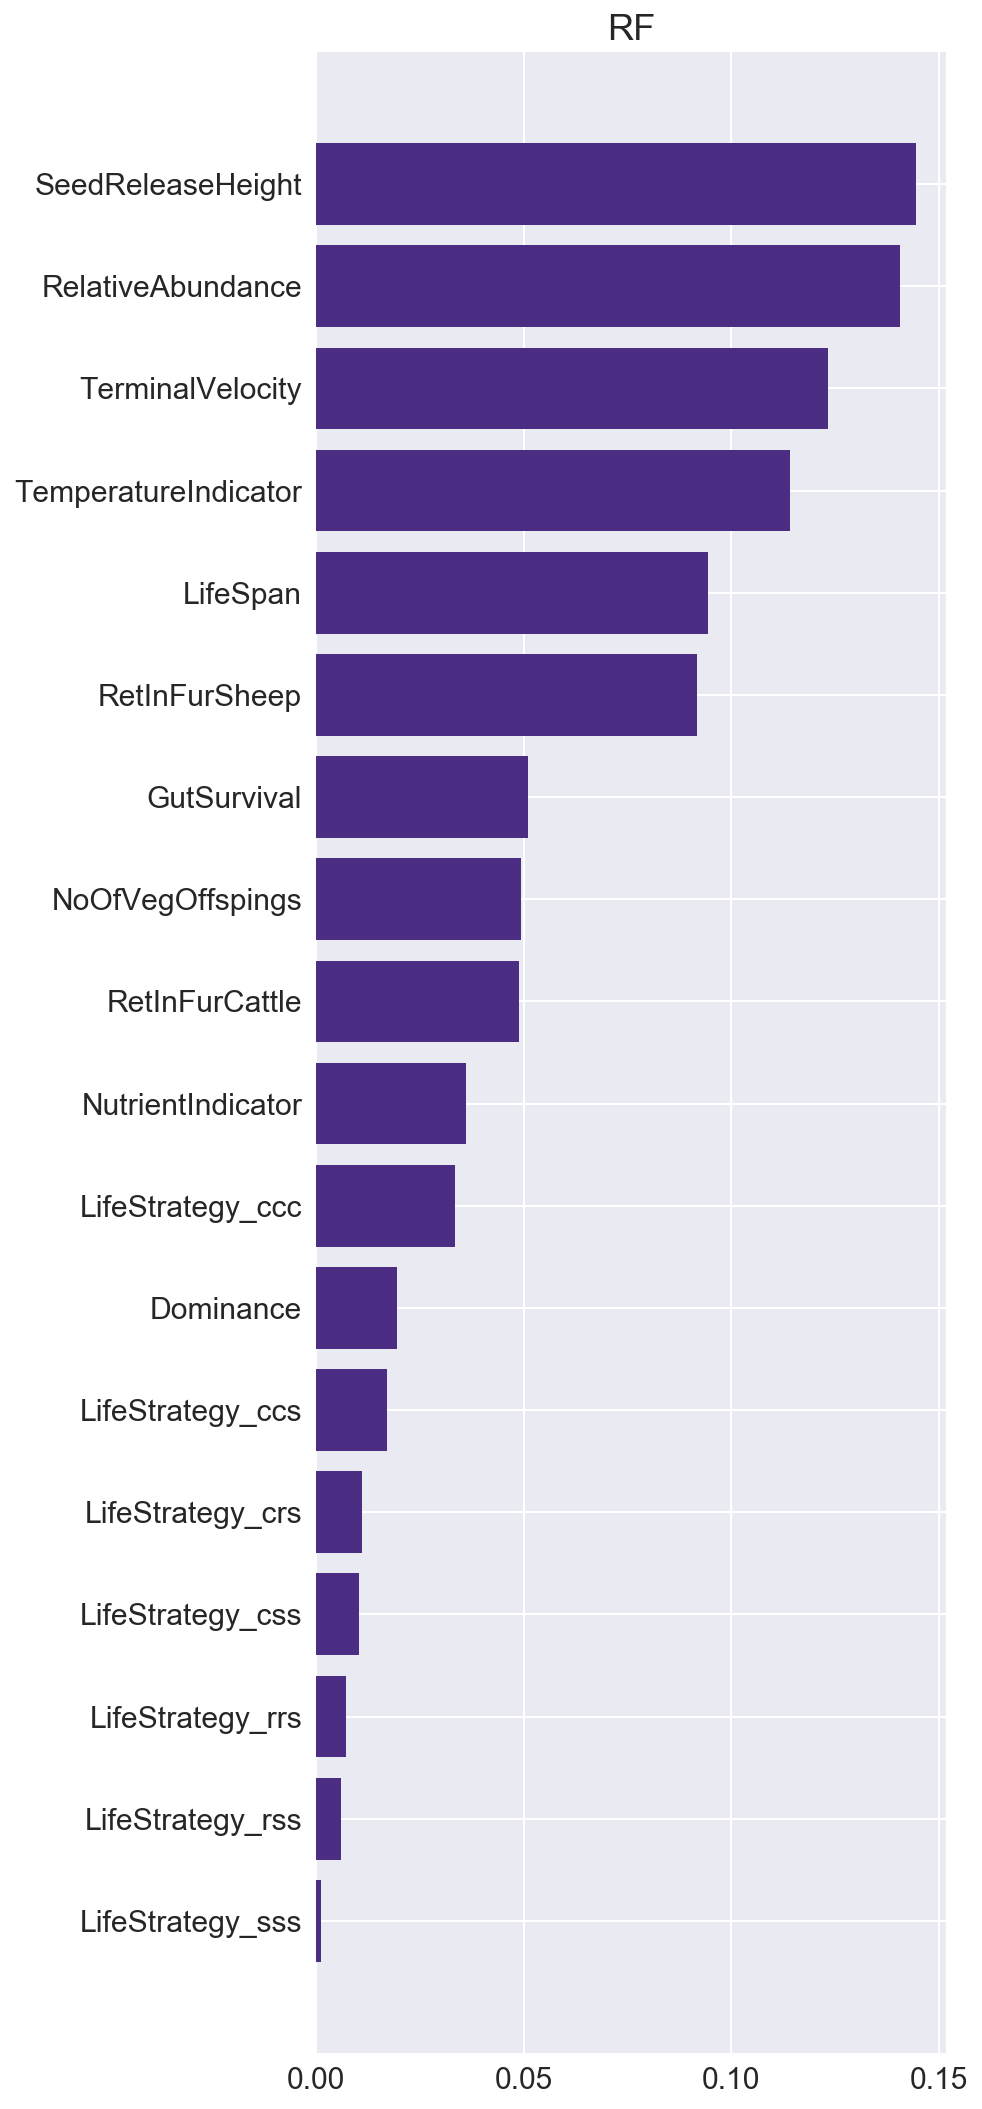

In [16]:
rf_coefs = []
rf_mses = []
for train, test in cv.split(td.X, td.Y):    
    rf = RandomForestRegressor()
    rf.fit(td.X[train], td.Y[train])
    preds = rf.predict(td.X[test])
    error = mean_squared_error(td.Y[test], preds)
    rf_mses.append(error)
    rf_coefs.append(rf.feature_importances_)

mean_error = np.mean(rf_mses)
std_error = np.std(rf_mses)
mean_coefs = np.mean(rf_coefs, axis=0)
std_coefs = np.std(rf_coefs, axis=0)
    
MSEs.append(("RF", rf_mses))
COEFs.append(("RF", mean_coefs))
plot_importance(mean_coefs,
                td.feature_names, "RF",
                save="{}_rf-ranks.png".format(dsname))
rankings.append(['RF'] + list(compute_ranks(rf.feature_importances_)))

### Support Vectors

In [17]:
baseModel = SVR()
params_grid = {
    'C'     : np.logspace(-3, 1.2),
    'gamma' : np.logspace(-3, 1.2),
    'degree': [0, 1, 2],
    'kernel': ['linear', 'poly', 'rbf']
}
gridSearch = GridSearchCV(baseModel,
                         param_grid = params_grid,
                         scoring="neg_mean_squared_error",
                         error_score = 0,
                         n_jobs = -1)

svr_coefs = []
svr_mses = []



for train, test in list(cv.split(td.X, td.Y)):   
    print("CV Run Init")
    gridSearch.fit(td.X[train], td.Y[train])
    best = gridSearch.best_estimator_
    preds = gridSearch.best_estimator_.predict(td.X[test])
    error = mean_squared_error(preds, td.Y[test])
    svr_mses.append(error)
    shapdata = shap.DenseData(X_train, td.feature_names)
    explainer = shap.KernelExplainer(best.predict, shapdata, nsamples=100)
    svr_coefs.append(explainer.explain(np.mat(td.X[test])).effects)


CV Run Init
CV Run Init
CV Run Init


KeyboardInterrupt: 

In [ ]:
mean_error = np.mean(svr_mses)
std_error = np.std(svr_mses)
mean_coefs = np.mean(svr_coefs, axis=0)
std_coefs = np.std(svr_coefs, axis=0)



MSEs.append(("SVR", svr_mses))
COEFs.append(("SVR", mean_coefs))
plot_importance(mean_coefs,
                td.feature_names, "SVR",
                save="{}_svr-ranks.png".format(dsname))
rankings.append(['SVR'] + list(compute_ranks(mean_coefs)))

In [ ]:
results = pd.DataFrame(rankings, columns=["Method"] + td.feature_names).set_index("Method").T
results['mean'] = results.mean(axis=1)


In [ ]:
results.sort_values(by=['mean'])

In [ ]:
results.sort_values(by=['mean'])


In [ ]:
results.to_csv("{}-rank.csv".format(dsname))
from pandas.tools.plotting import table


In [ ]:
results = results.sort_values(by='mean')
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
tab = table(ax, results, loc='upper left')
tab.auto_set_font_size(False)
tab.set_fontsize(14)
tab.scale(1.2, 1.3)
fig.tight_layout()

In [ ]:

fig = plt.figure(figsize=(8, 4))
labels, errors = zip(*MSEs)
errors = np.array(errors)
error_means = np.mean(errors, axis=1)
error_stds = np.std(errors, axis=1)
labels = np.array(labels)
sorted_idx = np.argsort(error_means)[::-1]
plt.bar(range(0, len(MSEs)), error_means[sorted_idx])#, yerr=error_stds)
plt.xticks(range(0, len(MSEs)), labels[sorted_idx])
plt.ylabel("MSE")
plt.title(dataset['name'])
plt.savefig("{}-msecompare.png".format(dsname), dpi=200)

---
## Create Summary Plot of Coefficients
We transform our list of (method, [coefs]) pairs into a DataFrame indexed on the canonical ordering of features from the dataset. We then re-order the DataFrame using the sorted coefficients from the `results` dataframe. 

In [ ]:
coefs_df = pd.DataFrame(dict(COEFs), index=td.feature_names).loc[results.index]
display(coefs_df)
coefs_df = coefs_df.iloc[::-1] # not sure why but it seems like it needs to be reversed for plotting to work right?


In [ ]:
def coefsSubplot(coefs, method, ax, labels=None):
    bar_indices = np.arange(len(coefs))
    
    ax.barh(bar_indices,
             coefs,
             align='center', color='#4b2e83')
    
    if labels is not None:
        ax.set_yticks(bar_indices)
        ax.set_yticklabels(labels)
    ax.set_title(method)


In [ ]:
fig, axes = plt.subplots(nrows = 1,
                         ncols = len(coefs_df.columns), 
                         sharey = True, 
                         figsize=(20,10))
for i, c in enumerate(coefs_df.columns):
    if (i == 0):
        coefsSubplot(coefs_df[c].values, c, axes[i], labels=list(coefs_df.index))
    else: 
        coefsSubplot(coefs_df[c].values, c, axes[i], labels=None)
    
fig.tight_layout()

In [ ]:
list(coefs_df.index)